In [65]:
import pandas as pd
import numpy as np
import re
from typing import List, Tuple, Dict, Any, Set, Callable, Hashable
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from adapters import *
from distances.levenshtein import levenshtein_distance_memopt
from dcs import DCSEliminator
from winnowing import Winnowing
from snm import SNM
from dm_soundex import encode
from ngram import NGramm

In [66]:
column_names = [
  # 'rec_id',
  'given_name',
  'surname',
  'street_number',
  'address_1',
  'address_2',
  'suburb',
  # 'postcode',
  'state',
  'date_of_birth',
  # 'age',
  'phone_number',
  # 'soc_sec_id',
  # 'blocking_number'
]

In [67]:
def to_str(r: Dict[Hashable, Any]) -> str:
  s = ''
  for k in column_names:
    if r[k] is not None and isinstance(r[k], str) and r[k] != '':
      s += r[k]
  return s

In [68]:
def get_key(x: str) -> str:
    # Формируем ключ из значений полей
    return  '-'.join([x.split('-')[0], x.split('-')[1]])

In [69]:
data = pd.read_csv('test.csv', dtype=str)
data = data.applymap(lambda x:  x.strip() if isinstance(x, str) else x )
# data['address_1'] = data['address_1'].apply(lambda x:  clean_address(x) if isinstance(x, str) else x )
# data['address_2'] = data['address_2'].apply(lambda x:  clean_address(x) if isinstance(x, str) else x )
# data = data.applymap(lambda x:  clean_address(x) if isinstance(x, str) else x )
data = data.replace({np.nan:None})
data['rec_common_id'] = data.apply(lambda x: get_key(x['rec_id']), axis=1)
data_list = data.to_dict('records')

In [70]:
data_by_ids: Dict[str, List[Dict[Hashable, Any]]] = {}
expected_res: Dict[str, Set[str]] = {}
origs: Dict[str, Dict[Hashable, Any]] = {}
for record in data_list:
    if record['rec_common_id'] not in data_by_ids:
        data_by_ids[record['rec_common_id']] = []
        expected_res[record['rec_common_id']] = set()
    data_by_ids[record['rec_common_id']].append(record)
    expected_res[record['rec_common_id']].add(record['rec_id'])
    if 'org' in record['rec_id']:
        origs[record['rec_id']] = record

In [71]:
def test_distances(data: List[Dict[Hashable, Any]], expected_res: Dict[str, Set[str]], similarity: Callable[[Dict[Hashable, Any], Dict[Hashable, Any]], float],threshold: float = 0.85) -> Tuple[int, int, int]:
  tp = 0
  fp = 0
  fn = 0
  res = []
  # found_records = [False for _ in range(len(data))]
  # inverted_idx: Dict[str, int] = {}

  # for i in range(len(data)):
  #   inverted_idx[data[i]['rec_id']] = i
  
  for i in range(len(data)):
    # if found_records[inverted_idx[data[i]['rec_id']]]:
    #   continue
    # found_records[inverted_idx[data[i]['rec_id']]] = True
    for j in range(i + 1, len(data)):
      sim = similarity(data[i], data[j])
      if sim > threshold:
        res.append((data[i]['rec_id'], data[j]['rec_id'], sim))
        # found_records[inverted_idx[data[j]['rec_id']]] = True
  res_by_ids = {}
  for (a_id, b_id, sim) in res:
    a_key = get_key(a_id)
    b_key = get_key(b_id)
    if a_key != b_key:
      print(f'ERROR: {a_id}, {b_id}, {sim}')
      fp += 1
      continue
    if a_key not in res_by_ids:
      res_by_ids[a_key] = set()
    res_by_ids[a_key].add(a_id)
    res_by_ids[a_key].add(b_id)
  for key in expected_res:
    if key not in res_by_ids:
      if len(expected_res[key]) > 1:
        # print(f'ERROR: not found {key}')
        fn += len(expected_res[key])
      continue
    # if len(expected_res[key]) != len(res_by_ids[key]):
    #   print(f'ERROR: not full {key}')
    fn += len(expected_res[key]) - len(res_by_ids[key])
    tp += len(res_by_ids[key])
  return tp, fp, fn

In [72]:
(tp, fp, fn) = test_distances(data_list, expected_res, get_lev_sim(column_names))
print('LEVENSTEIN')
print(f'tp: {tp}, fp: {fp}, fn: {fn}')
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {2 * precision * recall / (precision + recall)}')

LEVENSTEIN
tp: 422, fp: 0, fn: 118
precision: 1.0
recall: 0.7814814814814814
f1: 0.8773388773388773


In [73]:
(tp, fp, fn) = test_distances(data_list, expected_res, get_jaro_sim(column_names))
print('JARO')
print(f'tp: {tp}, fp: {fp}, fn: {fn}')
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {2 * precision * recall / (precision + recall)}')

JARO
tp: 461, fp: 0, fn: 79
precision: 1.0
recall: 0.8537037037037037
f1: 0.9210789210789212


In [74]:
(tp, fp, fn) = test_distances(data_list, expected_res, get_dam_lev_sim(column_names))
print('DAMERAU LEVENSTEIN')
print(f'tp: {tp}, fp: {fp}, fn: {fn}')
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {2 * precision * recall / (precision + recall)}')

DAMERAU LEVENSTEIN
tp: 425, fp: 0, fn: 115
precision: 1.0
recall: 0.7870370370370371
f1: 0.8808290155440415


In [75]:
(tp, fp, fn) = test_distances(data_list, expected_res, get_jaccard_sim(column_names))
print('JACCARD')
print(f'tp: {tp}, fp: {fp}, fn: {fn}')
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {2 * precision * recall / (precision + recall)}')

JACCARD
tp: 422, fp: 0, fn: 118
precision: 1.0
recall: 0.7814814814814814
f1: 0.8773388773388773


In [76]:
def dcs_key(r: Dict[Hashable, Any]) -> str:
  name = r['given_name']
  sur = r['surname']
  if name is None:
    name = ''
  # elif name != '':
  #   name = encode(name, max_length=10, zero_pad=True)
  if sur is None:
    sur = ''
  # elif sur != '':
  #   sur = encode(sur, max_length=10, zero_pad=True)
  name.replace(' ', '')
  sur.replace(' ', '')
  s = f'{name}{sur}'
  if s == '':
    return '0'*10
  # print(encode(r['surname'], max_length=10, zero_pad=True))
  return s
# def is_duplicate(threshold: float = 0.7) -> Callable[[Dict[Hashable, Any], Dict[Hashable, Any]], bool]:
#   return lambda r1, r2: get_jaccard_sim(r1, r2) > threshold

In [77]:
def get_stats(res: List[Tuple[Dict[Hashable, Any], Dict[Hashable, Any]]], expected_res) -> Tuple[int, int, int, float, float, float]:
  tp = 0
  fp = 0
  fn = 0
  res_by_ids = {}
  for (a, b) in res:
    a_id = a['rec_id']
    b_id = b['rec_id']
    if a_id == b_id:
      print(f'ERROR: {a_id}, {b_id}')
      continue
    a_key = get_key(a_id)
    b_key = get_key(b_id)
    if a_key != b_key:
      # print(f'ERROR: {a_id}, {b_id}, {sim}')
      fp += 1
      continue
    if a_key not in res_by_ids:
      res_by_ids[a_key] = set()
    res_by_ids[a_key].add(a_id)
    res_by_ids[a_key].add(b_id)
  for key in expected_res:
    if key not in res_by_ids:
      if len(expected_res[key]) > 1:
        # print(f'ERROR: not found {key}')
        fn += len(expected_res[key])
      continue
    # if len(expected_res[key]) != len(res_by_ids[key]):
    #   print(f'ERROR: not full {key}')
    fn += len(expected_res[key]) - len(res_by_ids[key])
    tp += len(res_by_ids[key])
  precision = 0
  if tp + fp != 0:
    precision = tp / (tp + fp)
  recall = 0
  if tp + fn != 0:
    recall = tp / (tp + fn)
  f1 = 0
  if precision + recall != 0:
    f1 = 2 * precision * recall / (precision + recall)
  return tp, fp, fn, precision, recall, f1

def res_stats(res: List[Tuple[Dict[Hashable, Any], Dict[Hashable, Any]]], expected_res) -> None:
  tp, fp, fn, precision, recall, f1 = get_stats(res, expected_res)
  print(f'tp: {tp}, fp: {fp}, fn: {fn}')
  print(f'precision: {precision}')
  print(f'recall: {recall}')
  print(f'f1: {f1}')

In [78]:
de = DCSEliminator(data_list, dcs_key, get_jaccard_sim(column_names), w=20)
res = de.find_duplicates(0.8)
cnt = de.get_comparison_count()
cnt

286

In [79]:
res_stats(res, expected_res)

tp: 424, fp: 0, fn: 116
precision: 1.0
recall: 0.7851851851851852
f1: 0.8796680497925311


In [80]:
def get_lev_dist(a: Dict[Hashable, Any], b: Dict[Hashable, Any]) -> int:
  a_s = ''
  b_s = ''
  for k in column_names:
    if a[k] is not None and isinstance(a[k], str) and a[k] != '' and b[k] is not None and isinstance(b[k], str) and b[k] != '':
      a_s += a[k]
      b_s += b[k]
  return levenshtein_distance_memopt(a_s, b_s)

In [81]:
from bk_tree import BKTree

In [82]:
bkt = BKTree(get_lev_dist)
for r in data_list:
  bkt.insert(r)

res: List[Tuple[Dict[Hashable, Any], Dict[Hashable, Any]]] = []
qres = []
for org in origs.values():
  q_res = bkt.query(org, 15)
  for (_,r) in q_res:
    if r['rec_id'] != org['rec_id']:
      res.append((org, r))

res_stats(res, expected_res)

tp: 520, fp: 12, fn: 20
precision: 0.9774436090225563
recall: 0.9629629629629629
f1: 0.9701492537313433


In [83]:
from bk2 import BKTree as BK2

In [84]:
bk2 = BK2(get_lev_dist)
for r in data_list:
  bk2.insert(r)

res: List[Tuple[Dict[Hashable, Any], Dict[Hashable, Any]]] = []
for org in origs.values():
  q_res = bk2.search(org, 15)
  for (_,r) in q_res:
    if r['rec_id'] != org['rec_id']:
      res.append((org, r))

res_stats(res, expected_res)

tp: 520, fp: 12, fn: 20
precision: 0.9774436090225563
recall: 0.9629629629629629
f1: 0.9701492537313433


In [85]:
def snm_key(r: Dict[Hashable, Any]) -> str:
  name = r['given_name']
  sur = r['surname']
  if name is None:
    name = ''
  elif name != '':
    name = encode(name, max_length=10, zero_pad=True)
  if sur is None:
    sur = ''
  elif sur != '':
    sur.replace(' ', '')
    sur = encode(sur, max_length=10, zero_pad=True)
  s = f'{name}{sur}'
  if s == '':
    return '0'*10
  return s

In [86]:
snm = SNM(data_list, snm_key, get_jaccard_sim(column_names), w=10)
res = snm.find_duplicates(0.7)
cnt = snm.get_comparison_count()
cnt

5355

In [87]:
res_stats(res, expected_res)

tp: 436, fp: 0, fn: 104
precision: 1.0
recall: 0.8074074074074075
f1: 0.8934426229508198


In [88]:
ng = NGramm(data=data_list, to_str=to_str, n=5)
res = ng.find_duplicates(0.45)
cnt = ng.get_comparison_count()

In [89]:
res_stats(res, expected_res)

tp: 534, fp: 0, fn: 6
precision: 1.0
recall: 0.9888888888888889
f1: 0.9944134078212291


In [90]:
ks = np.arange(1, 11)
ws = np.arange(1, 11)
# nu = np.zeros( (ws.size, ks.size) )
# cnts = np.zeros( (ws.size, ks.size) )
ts = np.arange(0.1, 0.9, 0.05)
nu = np.zeros( (ts.size, ks.size) )
cnts = np.zeros( (ts.size, ks.size) )
counter_y = 0
for k in ks:
  counter_x = 0
  # for w in ws:
  for t in ts:
    win = Winnowing(data_list, to_str, k, 9)
    res = win.find_duplicates(t)
    cnt = win.get_comparison_count()
    (_, _, _, _, _, f1) = get_stats(res, expected_res)
    nu[counter_x, counter_y] = f1
    cnts[counter_x, counter_y] = cnt
    counter_x += 1
  counter_y += 1

In [91]:
fig = go.Figure(data=[go.Surface(z=nu, x=ks, y=ts)])
fig.update_layout(title='Winnowing F1', autosize=False,
                  width=500, height=500, scene = dict(
                    yaxis_title='t',
                    xaxis_title='k',
                    zaxis_title='f1'))

In [92]:
fig = go.Figure(data=[go.Surface(z=cnts, x=ks, y=ts)])
fig.update_layout(title='Winnowing CNT', autosize=False,
                  width=500, height=500, scene = dict(
                    yaxis_title='w',
                    xaxis_title='k',
                    zaxis_title='f1'))

In [93]:
fig = go.Figure(data=[go.Surface(z=2*(nu)*(1-cnts/len(data_list))/((nu)+(1-cnts/len(data_list))), x=ts, y=ks)])
fig.update_layout(title='Winnowing', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='k',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [94]:
ts = np.arange(0.1, 0.9, 0.05)
ws = np.arange(1, 11)
nu = np.zeros( (ws.size, ts.size) )
ps = np.zeros( (ws.size, ts.size) )
rs = np.zeros( (ws.size, ts.size) )
cnts = np.zeros( (ws.size, ts.size) )
counter_y = 0
for t in ts:
  counter_x = 0
  for w in ws:
    snm = SNM(data_list, snm_key, get_jaccard_sim(column_names), w=w)
    res = snm.find_duplicates(t)
    cnt = snm.get_comparison_count()
    (_, _, _, p, r, f1) = get_stats(res, expected_res)
    nu[counter_x, counter_y] = f1
    ps[counter_x, counter_y] = p
    rs[counter_x, counter_y] = r
    cnts[counter_x, counter_y] = cnt
    counter_x += 1
  counter_y += 1

In [95]:
fig = go.Figure(data=[go.Surface(z=nu, x=ts, y=ws)])
fig.update_layout(title='SNM F1', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='w',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [96]:
fig = go.Figure(data=[go.Surface(z=cnts, x=ts, y=ws)])
fig.update_layout(title='SNM CNT', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='w',
                    xaxis_title='threshold',
                    zaxis_title='cnt'))

In [97]:
# fig = go.Figure(data=[go.Surface(z=ps, x=ts, y=ws)])
# fig.update_layout(title='SNM PRECISION', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90), scene = dict(
#                     yaxis_title='w',
#                     xaxis_title='threshold',
#                     zaxis_title='precision'))

In [98]:
# fig = go.Figure(data=[go.Surface(z=rs, x=ts, y=ws)])
# fig.update_layout(title='SNM RECALL', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90), scene = dict(
#                     yaxis_title='w',
#                     xaxis_title='threshold',
#                     zaxis_title='recall'))

In [109]:
ts = np.arange(0.4, 0.9, 0.05)
ws = np.arange(5, 30)
nu = np.zeros( (ws.size, ts.size) )
cnts = np.zeros( (ws.size, ts.size) )
counter_y = 0
for t in ts:
  counter_x = 0
  for w in ws:
    de = DCSEliminator(data_list, dcs_key, get_jaccard_sim(column_names), w=w)
    res = de.find_duplicates(t)
    cnt = de.get_comparison_count()
    (_, _, _, _, _, f1) = get_stats(res, expected_res)
    nu[counter_x, counter_y] = f1
    cnts[counter_x, counter_y] = cnt
    counter_x += 1
  counter_y += 1

In [110]:
fig = go.Figure(data=[go.Surface(z=nu, x=ts, y=ws)])
fig.update_layout(title='DCS F1', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='w',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [111]:
fig = go.Figure(data=[go.Surface(z=cnts, x=ts, y=ws)])
fig.update_layout(title='DCS CNT', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='w',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [113]:
fig = go.Figure(data=[go.Surface(z=2*(nu)*(1-cnts/cnts.max())/((nu)+(1-cnts/cnts.max())), x=ts, y=ws)])
fig.update_layout(title='DCS', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='w',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [103]:
ts = np.arange(0.4, 0.9, 0.05)
ps = []
rs = []
fs = []
cnts = []
for t in ts:
  de = DCSEliminator(data_list, dcs_key, get_jaccard_sim(column_names), w=10)
  res = de.find_duplicates(t)
  cnt = de.get_comparison_count()
  (_, _, _, p, r, f1) = get_stats(res, expected_res)
  ps.append(p)
  rs.append(r)
  fs.append(f1)
  cnts.append(cnt/len(data_list))

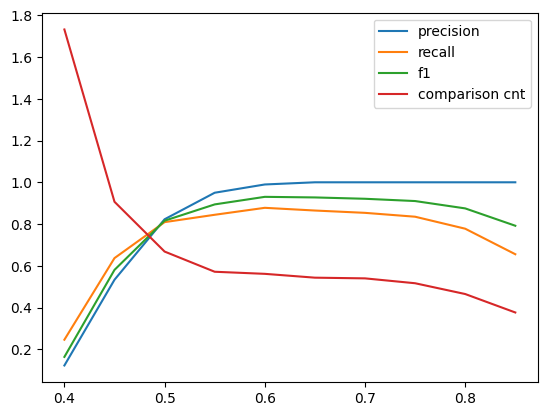

In [104]:
plt.plot(ts, ps, label='precision')
plt.plot(ts, rs, label='recall')
plt.plot(ts, fs, label='f1')
plt.plot(ts, cnts, label='cnt')
plt.legend(['precision', 'recall', 'f1', 'comparison cnt'])

In [105]:
ts = np.arange(0.1, 0.9, 0.05)
ws = np.arange(3, 20)
nu = np.zeros( (ws.size, ts.size) )
cnts = np.zeros( (ws.size, ts.size) )
counter_y = 0
for t in ts:
  counter_x = 0
  for w in ws:
    ng = NGramm(data=data_list, to_str=to_str, n=w)
    res = ng.find_duplicates(t)
    cnt = ng.get_comparison_count()
    (_, _, _, _, _, f1) = get_stats(res, expected_res)
    nu[counter_x, counter_y] = f1
    cnts[counter_x, counter_y] = cnt
    counter_x += 1
  counter_y += 1

In [106]:
fig = go.Figure(data=[go.Surface(z=nu, x=ts, y=ws)])
fig.update_layout(title='NGRAMM', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='n',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [107]:
fig = go.Figure(data=[go.Surface(z=cnts, x=ts, y=ws)])
fig.update_layout(title='NGRAMM', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = dict(
                    yaxis_title='n',
                    xaxis_title='threshold',
                    zaxis_title='f1'))

In [108]:
# fig = go.Figure(data=[go.Surface(z=(nu)*(1-cnts/np.max(cnts)), x=ts, y=ws)])
# fig.update_layout(title='NGRAMM', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90), scene = dict(
#                     yaxis_title='w',
#                     xaxis_title='threshold',
#                     zaxis_title='f1'))